# Выбор оптимальной модели

В этом семинаре мы потренируемся обучению, оценке и валидации моделей, подбору оптимальных гиперпараметров, смешиванию моделей. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() #этот метод разделит датасет по колонкам как в массиве columns

df = df.replace('?', np.nan)

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x==' >50K')) # Будем предсказывать 1(True), если зарплата больше 50K, 0(False) иначе

In [3]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
dummy_features = pd.get_dummies(categorial_data)

In [4]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
y = df['salary']

Теперь всё готово для обучения алгоритмов.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8)

/Users/anastasiazuhba/anaconda3/envs/Py3ML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. 

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='roc_auc', n_jobs=-1)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score')

        plt.fill_between(grid, means - 2 * error, means + 2 * error, color='green', label='filled area between errors', alpha=0.2)
        plt.legend()
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [11]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(2, 100, 10), dtype='int'), np.arange(1, 21)]
param_scales = ['log', 'ordinary']

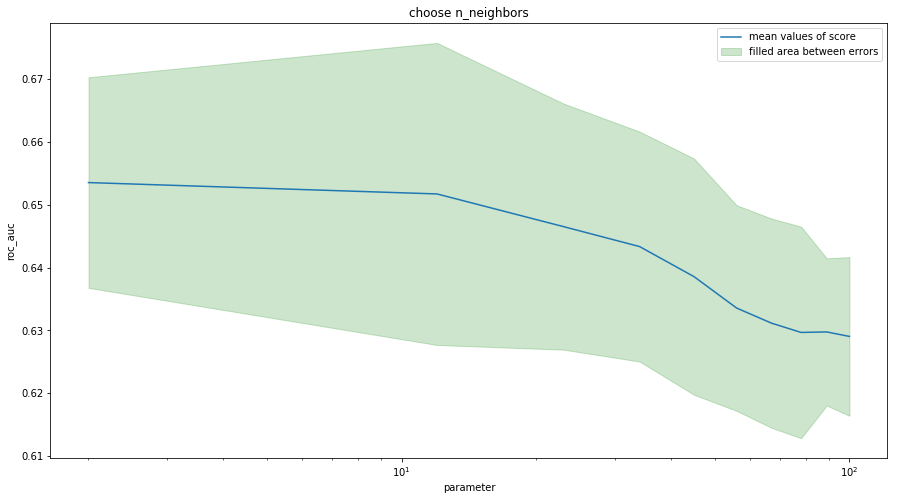

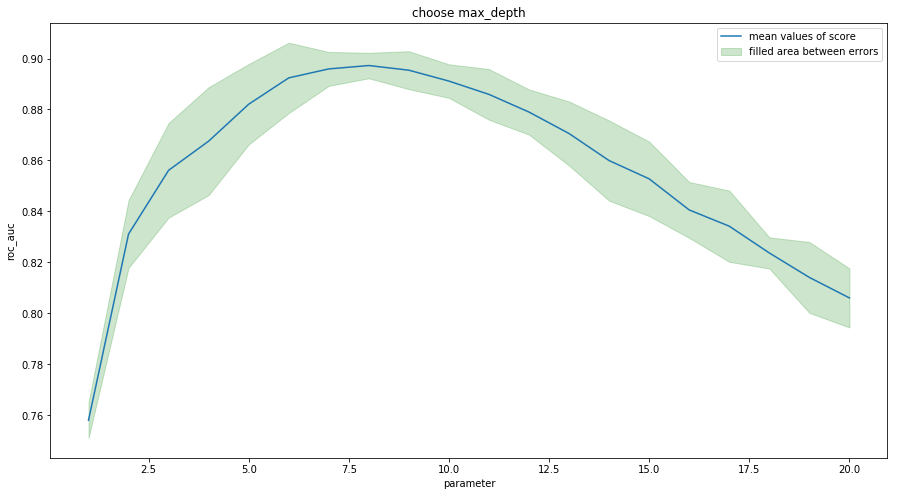

In [12]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется. 
Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [15]:
max_trees = 200

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

for train_indices, val_indices in kf.split(X_train):
    scores = []
    
    X_train_kf = X_train[train_indices]
    y_train_kf = y_train[train_indices]
    
    X_val_kf = X_train[val_indices]
    y_val_kf = y_train[val_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in values:
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))
    
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

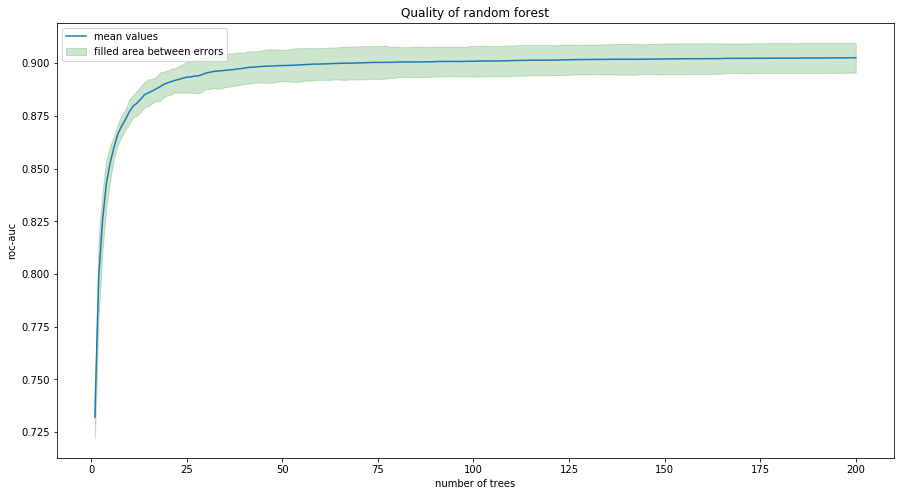

In [16]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values')
plt.fill_between(values, 
                 mean_cross_val_score - 2 * std_cross_val_score, 
                 mean_cross_val_score + 2 * std_cross_val_score, 
                 color='green', 
                 label='filled area between errors', alpha=0.2 )
plt.legend()
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

Нормируем признаки и проделаем тот же эксперимент с алгоритмом ближайших соседей. Посмотрим, изменилось ли качество предсказания.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/Users/anastasiazuhba/anaconda3/envs/Py3ML/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


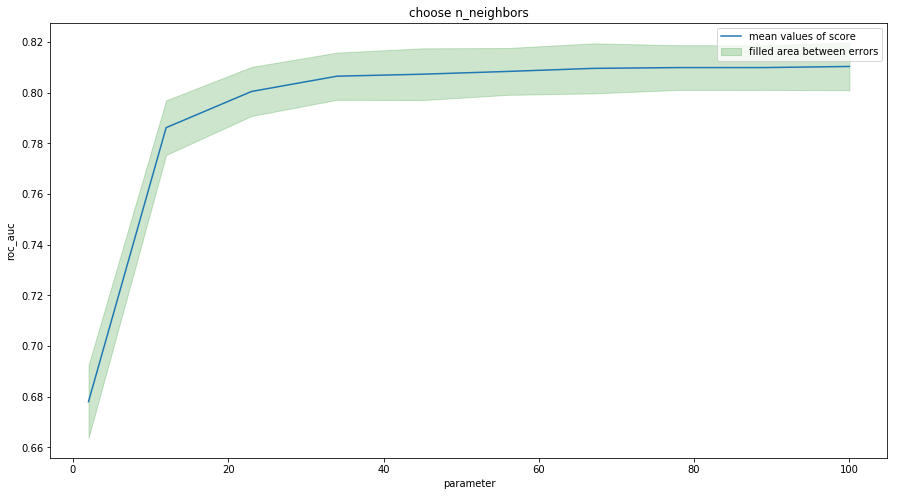

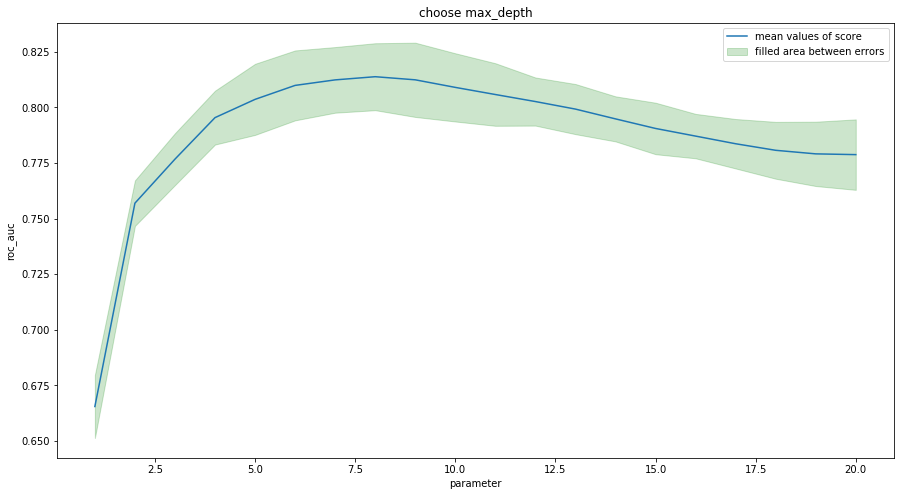

In [18]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(2, 100, 10), dtype='int'), np.arange(1, 21)]
param_scales = ['ordinary', 'ordinary']

for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train[:, numeric_indices], y_train, model, param_name, grid, param_scale)

In [19]:
search_and_draw(X_train, y_train, KNeighborsClassifier(), 'n_neighbors', [30], param_scale, draw=False)

(array([0.86958939]), array([0.0030806]))

Как и следовало ожидать, ни один из наших алгоритмов не побил случайный лес. Итак, видим, что на больших выборках бэггинг работает. Вычислим итоговое качество на test.

In [20]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)

model.fit(X_train, y_train)
y_predicted = model.predict_proba(X_test)[:, 1]

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

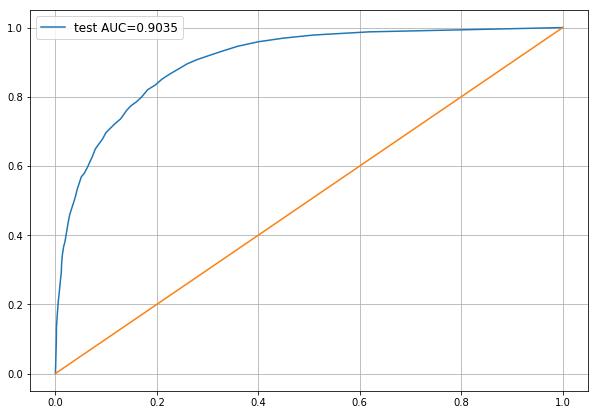

In [22]:
auc = roc_auc_score(y_test, y_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_test, y_predicted)[:2], label='test AUC=%.4f' % auc)
plt.legend(fontsize='large')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.show()

## Что ещё можно делать:

Мы подбирали оптимальный одномерный параметр для алгоритма. Можно также:

* Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

* Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

# Стекинг

Идея стекинга состоит в том, чтобы обучать разнообразные алгоритмы и использовать их в качестве новых признаков объектов. 

Чтобы избежать переобучения, необходимо разделить обучающую выборку на n фолдов. Для предсказания ответов на k-ом фолде алгоритм обучается на оставшихся n-1 фолдах и предсказывает ответ на k-ом фолде. Такую схему обучения-предсказания реализует функция sklearn.model_selection.cross_val_predict.

In [23]:
from sklearn.model_selection import cross_val_predict

Будем работать с тем же самым датасетом, что и ранее. Посмотрим, сумеем ли мы побить результаты случайного леса с помощью стекинга.

In [24]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [26]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [27]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [28]:
for model in models:
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)
    print(1)

1
1
1
1
1


In [29]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

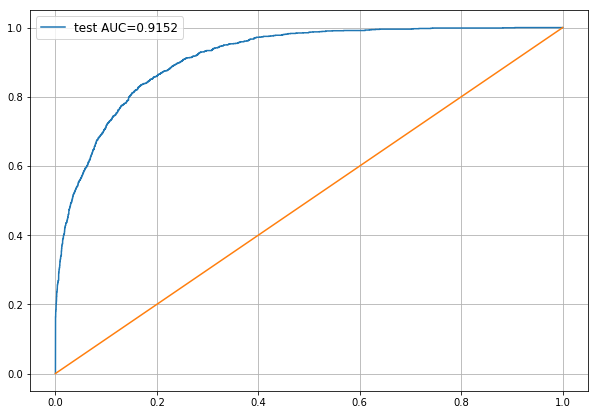

In [30]:
auc = roc_auc_score(y_test, y_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_test, y_predicted)[:2], label='test AUC=%.4f' % auc)
plt.legend(fontsize='large')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.show()

In [ ]:
auc = roc_auc_score(y_test, y_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_test, y_predicted)[:2], label='test AUC=%.4f' % auc)
plt.legend(fontsize='large')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.show()